In [49]:
import pandas as  pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [50]:
data = pd.read_csv('Drinks.csv')
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,Class 1,Class 2,Class 3
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009,1,0,0
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242,1,0,0
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148,1,0,0
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574,1,0,0
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874,1,0,0


In [51]:
data.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       'Class 1', 'Class 2', 'Class 3'],
      dtype='object')

In [52]:
np.random.seed(0)

y = data[['Class 1', 'Class 2', 'Class 3']].values

# Get inputs; we define our x and y here.\n",
X = data.drop(['Class 1', 'Class 2', 'Class 3'], axis=1)
X.shape, y.shape
X = X.values

In [53]:
def softmax(z):
    # Calculate exponent term first
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


def softmax_loss(y, y_hat):
    # Clipping valu
    minval = 0.000000000001
    # Number of samples
    m = y.shape[0]
    # Loss formula, note that np.sum sums up the entire matrix and therefore does the job of two sums from the formula\n",
    loss = -1 / m * np.sum(y * np.log(y_hat.clip(min=minval)))
    return loss

In [54]:
def loss_derivative(y, y_hat):
    return (y_hat - y)


In [55]:
def tanh_derivative(x):
    return (1 - np.power(x, 2))


In [56]:
# FORWARD PROPAGATION
# forward propagation function\n",
def forward_prop(model, a0):
    # Load parameters from model\n",
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    # Do the first Linear step \n",
    # Z1 is the input layer x times the dot product of the weights + our bias b\n",
    z1 = a0.dot(W1) + b1

    # Put it through the first activation function\n",
    a1 = np.tanh(z1)
    # Second linear step
    z2 = a1.dot(W2) + b2
    # Second activation function
    a2 = np.tanh(z2)
    # Third linear step
    z3 = a2.dot(W3) + b3

    # For the Third linear activation function we use the softmax function, either the sigmoid of softmax should be used for the last layer\n",
    a3 = softmax(z3)

    # Store all results in these values\n",
    cache = {'a0': a0, 'z1': z1, 'a1': a1, 'z2': z2, 'a2': a2, 'a3': a3, 'z3': z3}
    return cache

 

In [57]:
#backward propagation function
def backward_prop(model, cache, y):
    # Load parameters from model
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    # Load forward propagation results
    a0, a1, a2, a3 = cache['a0'], cache['a1'], cache['a2'], cache['a3']

    # Get number of samples\n",
    m = y.shape[0]

    # Calculate loss derivative with respect to output
    dz3 = loss_derivative(y=y, y_hat=a3)

    # Calculate loss derivative with respect to second layer weights
    dW3 = 1 / m * (a2.T).dot(dz3)  # dW2 = 1/m*(a1.T).dot(dz2)

    # Calculate loss derivative with respect to second layer bias

    db3 = 1 / m * np.sum(dz3, axis=0)

    # Calculate loss derivative with respect to first layer
    dz2 = np.multiply(dz3.dot(W3.T), tanh_derivative(a2))

    # Calculate loss derivative with respect to first layer weights
    dW2 = 1 / m * np.dot(a1.T, dz2)

    # Calculate loss derivative with respect to first layer bias
    db2 = 1 / m * np.sum(dz2, axis=0)

    dz1 = np.multiply(dz2.dot(W2.T), tanh_derivative(a1))

    dW1 = 1 / m * np.dot(a0.T, dz1)
    db1 = 1 / m * np.sum(dz1, axis=0)

    # Store gradients
    grads = {'dW3': dW3, 'db3': db3, 'dW2': dW2, 'db2': db2, 'dW1': dW1, 'db1': db1}
    return grads

  


In [58]:
  # TRAINING PHASE


def initialize_parameters(nn_input_dim, nn_hdim, nn_output_dim):
    # First layer weights
    W1 = 2 * np.random.randn(nn_input_dim, nn_hdim) - 1

    # First layer bias
    b1 = np.zeros((1, nn_hdim))

    # Second layer weights
    W2 = 2 * np.random.randn(nn_hdim, nn_hdim) - 1

    # Second layer bias
    b2 = np.zeros((1, nn_hdim))
    W3 = 2 * np.random.rand(nn_hdim, nn_output_dim) - 1
    b3 = np.zeros((1, nn_output_dim))

    # Package and return model
    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    return model


def update_parameters(model, grads, learning_rate):
    # Load parameters\n",
    W1, b1, W2, b2, b3, W3 = model['W1'], model['b1'], model['W2'], model['b2'], model['b3'], model["W3"]

    # Update parameters
    W1 -= learning_rate * grads['dW1']
    b1 -= learning_rate * grads['db1']
    W2 -= learning_rate * grads['dW2']
    b2 -= learning_rate * grads['db2']
    W3 -= learning_rate * grads['dW3']
    b3 -= learning_rate * grads['db3']

    # Store and return parameters\n",
    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    return model



In [59]:
def predict(model, x):
    # Do forward pass
    c = forward_prop(model, x)
    # get y_hat
    y_hat = np.argmax(c['a3'], axis=1)
    return y_hat

In [60]:
def calc_accuracy(model, x, y):
    # Get total number of examples
    m = y.shape[0]

    # Do a prediction with the model
    pred = predict(model, x)

    # Ensure prediction and truth vector y have the same shape
    pred = pred.reshape(y.shape)

    # Calculate the number of wrong examples
    error = np.sum(np.abs(pred - y))

    # Calculate accuracy
    return (m - error) / m * 100

In [61]:
  losses = []

def train(model, X_, y_, learning_rate, epochs=20000, print_loss=False):
    # Gradient descent. Loop over epochs
  
    for i in range(0, epochs):

        # Forward propagation
        cache = forward_prop(model, X_)
        # a1, probs = cache['a1'],cache['a2']
        # Backpropagation

        grads = backward_prop(model, cache, y_)
        # Gradient descent parameter update
        # Assign new parameters to the model
        model = update_parameters(model=model, grads=grads, learning_rate=learning_rate)

        # Pring loss & accuracy every 100 iterations
        if print_loss and i % 100 == 0:
            a3 = cache['a3']
        print('Loss after iteration', i, ':', softmax_loss(y_, a3))
        y_hat = predict(model, X_)
        y_true = y_.argmax(axis=1)
        print('Accuracy after iteration', i, ':', accuracy_score(y_pred=y_hat, y_true=y_true) * 100, '%')
        losses.append(accuracy_score(y_pred=y_hat, y_true=y_true) * 100)
    return model
np.random.seed(0)


Loss after iteration 0 : 1.4504813381979211
Accuracy after iteration 0 : 25.280898876404496 %
Loss after iteration 1 : 1.4504813381979211
Accuracy after iteration 1 : 26.40449438202247 %
Loss after iteration 2 : 1.4504813381979211
Accuracy after iteration 2 : 26.40449438202247 %
Loss after iteration 3 : 1.4504813381979211
Accuracy after iteration 3 : 26.96629213483146 %
Loss after iteration 4 : 1.4504813381979211
Accuracy after iteration 4 : 27.52808988764045 %
Loss after iteration 5 : 1.4504813381979211
Accuracy after iteration 5 : 29.775280898876407 %
Loss after iteration 6 : 1.4504813381979211
Accuracy after iteration 6 : 30.89887640449438 %
Loss after iteration 7 : 1.4504813381979211
Accuracy after iteration 7 : 44.38202247191011 %
Loss after iteration 8 : 1.4504813381979211
Accuracy after iteration 8 : 46.62921348314607 %
Loss after iteration 9 : 1.4504813381979211
Accuracy after iteration 9 : 51.12359550561798 %
Loss after iteration 10 : 1.4504813381979211
Accuracy after iteratio

Loss after iteration 136 : 0.5255210272876467
Accuracy after iteration 136 : 83.14606741573034 %
Loss after iteration 137 : 0.5255210272876467
Accuracy after iteration 137 : 83.14606741573034 %
Loss after iteration 138 : 0.5255210272876467
Accuracy after iteration 138 : 83.14606741573034 %
Loss after iteration 139 : 0.5255210272876467
Accuracy after iteration 139 : 83.70786516853933 %
Loss after iteration 140 : 0.5255210272876467
Accuracy after iteration 140 : 83.70786516853933 %
Loss after iteration 141 : 0.5255210272876467
Accuracy after iteration 141 : 83.70786516853933 %
Loss after iteration 142 : 0.5255210272876467
Accuracy after iteration 142 : 83.70786516853933 %
Loss after iteration 143 : 0.5255210272876467
Accuracy after iteration 143 : 83.70786516853933 %
Loss after iteration 144 : 0.5255210272876467
Accuracy after iteration 144 : 83.70786516853933 %
Loss after iteration 145 : 0.5255210272876467
Accuracy after iteration 145 : 84.26966292134831 %
Loss after iteration 146 : 0.5

Loss after iteration 262 : 0.3964222056044325
Accuracy after iteration 262 : 87.07865168539325 %
Loss after iteration 263 : 0.3964222056044325
Accuracy after iteration 263 : 87.07865168539325 %
Loss after iteration 264 : 0.3964222056044325
Accuracy after iteration 264 : 87.07865168539325 %
Loss after iteration 265 : 0.3964222056044325
Accuracy after iteration 265 : 87.07865168539325 %
Loss after iteration 266 : 0.3964222056044325
Accuracy after iteration 266 : 87.07865168539325 %
Loss after iteration 267 : 0.3964222056044325
Accuracy after iteration 267 : 87.07865168539325 %
Loss after iteration 268 : 0.3964222056044325
Accuracy after iteration 268 : 87.07865168539325 %
Loss after iteration 269 : 0.3964222056044325
Accuracy after iteration 269 : 87.07865168539325 %
Loss after iteration 270 : 0.3964222056044325
Accuracy after iteration 270 : 87.07865168539325 %
Loss after iteration 271 : 0.3964222056044325
Accuracy after iteration 271 : 87.07865168539325 %
Loss after iteration 272 : 0.3

Loss after iteration 359 : 0.3469405969185754
Accuracy after iteration 359 : 88.76404494382022 %
Loss after iteration 360 : 0.3469405969185754
Accuracy after iteration 360 : 88.76404494382022 %
Loss after iteration 361 : 0.3469405969185754
Accuracy after iteration 361 : 88.76404494382022 %
Loss after iteration 362 : 0.3469405969185754
Accuracy after iteration 362 : 88.76404494382022 %
Loss after iteration 363 : 0.3469405969185754
Accuracy after iteration 363 : 88.76404494382022 %
Loss after iteration 364 : 0.3469405969185754
Accuracy after iteration 364 : 88.76404494382022 %
Loss after iteration 365 : 0.3469405969185754
Accuracy after iteration 365 : 88.76404494382022 %
Loss after iteration 366 : 0.3469405969185754
Accuracy after iteration 366 : 88.76404494382022 %
Loss after iteration 367 : 0.3469405969185754
Accuracy after iteration 367 : 88.76404494382022 %
Loss after iteration 368 : 0.3469405969185754
Accuracy after iteration 368 : 88.76404494382022 %
Loss after iteration 369 : 0.3

Loss after iteration 468 : 0.32062505328047924
Accuracy after iteration 468 : 89.32584269662921 %
Loss after iteration 469 : 0.32062505328047924
Accuracy after iteration 469 : 89.32584269662921 %
Loss after iteration 470 : 0.32062505328047924
Accuracy after iteration 470 : 89.32584269662921 %
Loss after iteration 471 : 0.32062505328047924
Accuracy after iteration 471 : 89.32584269662921 %
Loss after iteration 472 : 0.32062505328047924
Accuracy after iteration 472 : 89.32584269662921 %
Loss after iteration 473 : 0.32062505328047924
Accuracy after iteration 473 : 89.32584269662921 %
Loss after iteration 474 : 0.32062505328047924
Accuracy after iteration 474 : 89.32584269662921 %
Loss after iteration 475 : 0.32062505328047924
Accuracy after iteration 475 : 89.32584269662921 %
Loss after iteration 476 : 0.32062505328047924
Accuracy after iteration 476 : 89.32584269662921 %
Loss after iteration 477 : 0.32062505328047924
Accuracy after iteration 477 : 89.32584269662921 %
Loss after iteration

Loss after iteration 609 : 0.2775754239020053
Accuracy after iteration 609 : 89.8876404494382 %
Loss after iteration 610 : 0.2775754239020053
Accuracy after iteration 610 : 89.8876404494382 %
Loss after iteration 611 : 0.2775754239020053
Accuracy after iteration 611 : 89.8876404494382 %
Loss after iteration 612 : 0.2775754239020053
Accuracy after iteration 612 : 89.8876404494382 %
Loss after iteration 613 : 0.2775754239020053
Accuracy after iteration 613 : 89.8876404494382 %
Loss after iteration 614 : 0.2775754239020053
Accuracy after iteration 614 : 89.8876404494382 %
Loss after iteration 615 : 0.2775754239020053
Accuracy after iteration 615 : 89.8876404494382 %
Loss after iteration 616 : 0.2775754239020053
Accuracy after iteration 616 : 89.8876404494382 %
Loss after iteration 617 : 0.2775754239020053
Accuracy after iteration 617 : 89.8876404494382 %
Loss after iteration 618 : 0.2775754239020053
Accuracy after iteration 618 : 90.4494382022472 %
Loss after iteration 619 : 0.27757542390

Accuracy after iteration 750 : 90.4494382022472 %
Loss after iteration 751 : 0.25803463679942457
Accuracy after iteration 751 : 90.4494382022472 %
Loss after iteration 752 : 0.25803463679942457
Accuracy after iteration 752 : 90.4494382022472 %
Loss after iteration 753 : 0.25803463679942457
Accuracy after iteration 753 : 90.4494382022472 %
Loss after iteration 754 : 0.25803463679942457
Accuracy after iteration 754 : 90.4494382022472 %
Loss after iteration 755 : 0.25803463679942457
Accuracy after iteration 755 : 90.4494382022472 %
Loss after iteration 756 : 0.25803463679942457
Accuracy after iteration 756 : 90.4494382022472 %
Loss after iteration 757 : 0.25803463679942457
Accuracy after iteration 757 : 90.4494382022472 %
Loss after iteration 758 : 0.25803463679942457
Accuracy after iteration 758 : 90.4494382022472 %
Loss after iteration 759 : 0.25803463679942457
Accuracy after iteration 759 : 90.4494382022472 %
Loss after iteration 760 : 0.25803463679942457
Accuracy after iteration 760 :

Loss after iteration 841 : 0.24518960914662333
Accuracy after iteration 841 : 90.4494382022472 %
Loss after iteration 842 : 0.24518960914662333
Accuracy after iteration 842 : 90.4494382022472 %
Loss after iteration 843 : 0.24518960914662333
Accuracy after iteration 843 : 90.4494382022472 %
Loss after iteration 844 : 0.24518960914662333
Accuracy after iteration 844 : 90.4494382022472 %
Loss after iteration 845 : 0.24518960914662333
Accuracy after iteration 845 : 90.4494382022472 %
Loss after iteration 846 : 0.24518960914662333
Accuracy after iteration 846 : 90.4494382022472 %
Loss after iteration 847 : 0.24518960914662333
Accuracy after iteration 847 : 90.4494382022472 %
Loss after iteration 848 : 0.24518960914662333
Accuracy after iteration 848 : 90.4494382022472 %
Loss after iteration 849 : 0.24518960914662333
Accuracy after iteration 849 : 90.4494382022472 %
Loss after iteration 850 : 0.24518960914662333
Accuracy after iteration 850 : 90.4494382022472 %
Loss after iteration 851 : 0.2

Loss after iteration 975 : 0.2345347299699388
Accuracy after iteration 975 : 90.4494382022472 %
Loss after iteration 976 : 0.2345347299699388
Accuracy after iteration 976 : 90.4494382022472 %
Loss after iteration 977 : 0.2345347299699388
Accuracy after iteration 977 : 90.4494382022472 %
Loss after iteration 978 : 0.2345347299699388
Accuracy after iteration 978 : 90.4494382022472 %
Loss after iteration 979 : 0.2345347299699388
Accuracy after iteration 979 : 90.4494382022472 %
Loss after iteration 980 : 0.2345347299699388
Accuracy after iteration 980 : 90.4494382022472 %
Loss after iteration 981 : 0.2345347299699388
Accuracy after iteration 981 : 90.4494382022472 %
Loss after iteration 982 : 0.2345347299699388
Accuracy after iteration 982 : 90.4494382022472 %
Loss after iteration 983 : 0.2345347299699388
Accuracy after iteration 983 : 90.4494382022472 %
Loss after iteration 984 : 0.2345347299699388
Accuracy after iteration 984 : 90.4494382022472 %
Loss after iteration 985 : 0.23453472996

Accuracy after iteration 1091 : 92.13483146067416 %
Loss after iteration 1092 : 0.224901853756763
Accuracy after iteration 1092 : 92.13483146067416 %
Loss after iteration 1093 : 0.224901853756763
Accuracy after iteration 1093 : 92.13483146067416 %
Loss after iteration 1094 : 0.224901853756763
Accuracy after iteration 1094 : 92.13483146067416 %
Loss after iteration 1095 : 0.224901853756763
Accuracy after iteration 1095 : 92.13483146067416 %
Loss after iteration 1096 : 0.224901853756763
Accuracy after iteration 1096 : 92.13483146067416 %
Loss after iteration 1097 : 0.224901853756763
Accuracy after iteration 1097 : 92.13483146067416 %
Loss after iteration 1098 : 0.224901853756763
Accuracy after iteration 1098 : 92.13483146067416 %
Loss after iteration 1099 : 0.224901853756763
Accuracy after iteration 1099 : 92.13483146067416 %
Loss after iteration 1100 : 0.21649115993849932
Accuracy after iteration 1100 : 92.13483146067416 %
Loss after iteration 1101 : 0.21649115993849932
Accuracy after i

Loss after iteration 1232 : 0.20897333560828457
Accuracy after iteration 1232 : 93.25842696629213 %
Loss after iteration 1233 : 0.20897333560828457
Accuracy after iteration 1233 : 93.25842696629213 %
Loss after iteration 1234 : 0.20897333560828457
Accuracy after iteration 1234 : 93.25842696629213 %
Loss after iteration 1235 : 0.20897333560828457
Accuracy after iteration 1235 : 93.25842696629213 %
Loss after iteration 1236 : 0.20897333560828457
Accuracy after iteration 1236 : 93.25842696629213 %
Loss after iteration 1237 : 0.20897333560828457
Accuracy after iteration 1237 : 93.25842696629213 %
Loss after iteration 1238 : 0.20897333560828457
Accuracy after iteration 1238 : 93.25842696629213 %
Loss after iteration 1239 : 0.20897333560828457
Accuracy after iteration 1239 : 93.25842696629213 %
Loss after iteration 1240 : 0.20897333560828457
Accuracy after iteration 1240 : 93.25842696629213 %
Loss after iteration 1241 : 0.20897333560828457
Accuracy after iteration 1241 : 93.25842696629213 %


Loss after iteration 1336 : 0.20186399701140648
Accuracy after iteration 1336 : 93.25842696629213 %
Loss after iteration 1337 : 0.20186399701140648
Accuracy after iteration 1337 : 93.25842696629213 %
Loss after iteration 1338 : 0.20186399701140648
Accuracy after iteration 1338 : 93.25842696629213 %
Loss after iteration 1339 : 0.20186399701140648
Accuracy after iteration 1339 : 93.25842696629213 %
Loss after iteration 1340 : 0.20186399701140648
Accuracy after iteration 1340 : 93.25842696629213 %
Loss after iteration 1341 : 0.20186399701140648
Accuracy after iteration 1341 : 93.25842696629213 %
Loss after iteration 1342 : 0.20186399701140648
Accuracy after iteration 1342 : 93.25842696629213 %
Loss after iteration 1343 : 0.20186399701140648
Accuracy after iteration 1343 : 93.25842696629213 %
Loss after iteration 1344 : 0.20186399701140648
Accuracy after iteration 1344 : 93.25842696629213 %
Loss after iteration 1345 : 0.20186399701140648
Accuracy after iteration 1345 : 93.25842696629213 %


Accuracy after iteration 1437 : 93.82022471910112 %
Loss after iteration 1438 : 0.18022550179247981
Accuracy after iteration 1438 : 93.82022471910112 %
Loss after iteration 1439 : 0.18022550179247981
Accuracy after iteration 1439 : 93.82022471910112 %
Loss after iteration 1440 : 0.18022550179247981
Accuracy after iteration 1440 : 93.82022471910112 %
Loss after iteration 1441 : 0.18022550179247981
Accuracy after iteration 1441 : 93.82022471910112 %
Loss after iteration 1442 : 0.18022550179247981
Accuracy after iteration 1442 : 93.82022471910112 %
Loss after iteration 1443 : 0.18022550179247981
Accuracy after iteration 1443 : 93.82022471910112 %
Loss after iteration 1444 : 0.18022550179247981
Accuracy after iteration 1444 : 93.82022471910112 %
Loss after iteration 1445 : 0.18022550179247981
Accuracy after iteration 1445 : 93.82022471910112 %
Loss after iteration 1446 : 0.18022550179247981
Accuracy after iteration 1446 : 93.82022471910112 %
Loss after iteration 1447 : 0.18022550179247981


Loss after iteration 1529 : 0.1669018228661394
Accuracy after iteration 1529 : 93.82022471910112 %
Loss after iteration 1530 : 0.1669018228661394
Accuracy after iteration 1530 : 93.82022471910112 %
Loss after iteration 1531 : 0.1669018228661394
Accuracy after iteration 1531 : 93.82022471910112 %
Loss after iteration 1532 : 0.1669018228661394
Accuracy after iteration 1532 : 93.82022471910112 %
Loss after iteration 1533 : 0.1669018228661394
Accuracy after iteration 1533 : 93.82022471910112 %
Loss after iteration 1534 : 0.1669018228661394
Accuracy after iteration 1534 : 93.82022471910112 %
Loss after iteration 1535 : 0.1669018228661394
Accuracy after iteration 1535 : 93.82022471910112 %
Loss after iteration 1536 : 0.1669018228661394
Accuracy after iteration 1536 : 93.82022471910112 %
Loss after iteration 1537 : 0.1669018228661394
Accuracy after iteration 1537 : 93.82022471910112 %
Loss after iteration 1538 : 0.1669018228661394
Accuracy after iteration 1538 : 93.82022471910112 %
Loss after

Loss after iteration 1621 : 0.15681341901851115
Accuracy after iteration 1621 : 94.3820224719101 %
Loss after iteration 1622 : 0.15681341901851115
Accuracy after iteration 1622 : 94.3820224719101 %
Loss after iteration 1623 : 0.15681341901851115
Accuracy after iteration 1623 : 94.3820224719101 %
Loss after iteration 1624 : 0.15681341901851115
Accuracy after iteration 1624 : 94.3820224719101 %
Loss after iteration 1625 : 0.15681341901851115
Accuracy after iteration 1625 : 94.3820224719101 %
Loss after iteration 1626 : 0.15681341901851115
Accuracy after iteration 1626 : 94.3820224719101 %
Loss after iteration 1627 : 0.15681341901851115
Accuracy after iteration 1627 : 94.3820224719101 %
Loss after iteration 1628 : 0.15681341901851115
Accuracy after iteration 1628 : 94.3820224719101 %
Loss after iteration 1629 : 0.15681341901851115
Accuracy after iteration 1629 : 94.3820224719101 %
Loss after iteration 1630 : 0.15681341901851115
Accuracy after iteration 1630 : 94.3820224719101 %
Loss after

Loss after iteration 1741 : 0.14891431157061522
Accuracy after iteration 1741 : 94.9438202247191 %
Loss after iteration 1742 : 0.14891431157061522
Accuracy after iteration 1742 : 94.9438202247191 %
Loss after iteration 1743 : 0.14891431157061522
Accuracy after iteration 1743 : 94.9438202247191 %
Loss after iteration 1744 : 0.14891431157061522
Accuracy after iteration 1744 : 94.9438202247191 %
Loss after iteration 1745 : 0.14891431157061522
Accuracy after iteration 1745 : 94.9438202247191 %
Loss after iteration 1746 : 0.14891431157061522
Accuracy after iteration 1746 : 94.9438202247191 %
Loss after iteration 1747 : 0.14891431157061522
Accuracy after iteration 1747 : 94.9438202247191 %
Loss after iteration 1748 : 0.14891431157061522
Accuracy after iteration 1748 : 94.9438202247191 %
Loss after iteration 1749 : 0.14891431157061522
Accuracy after iteration 1749 : 94.9438202247191 %
Loss after iteration 1750 : 0.14891431157061522
Accuracy after iteration 1750 : 94.9438202247191 %
Loss after

Loss after iteration 1852 : 0.1424065366570797
Accuracy after iteration 1852 : 95.50561797752809 %
Loss after iteration 1853 : 0.1424065366570797
Accuracy after iteration 1853 : 95.50561797752809 %
Loss after iteration 1854 : 0.1424065366570797
Accuracy after iteration 1854 : 95.50561797752809 %
Loss after iteration 1855 : 0.1424065366570797
Accuracy after iteration 1855 : 95.50561797752809 %
Loss after iteration 1856 : 0.1424065366570797
Accuracy after iteration 1856 : 95.50561797752809 %
Loss after iteration 1857 : 0.1424065366570797
Accuracy after iteration 1857 : 95.50561797752809 %
Loss after iteration 1858 : 0.1424065366570797
Accuracy after iteration 1858 : 95.50561797752809 %
Loss after iteration 1859 : 0.1424065366570797
Accuracy after iteration 1859 : 95.50561797752809 %
Loss after iteration 1860 : 0.1424065366570797
Accuracy after iteration 1860 : 95.50561797752809 %
Loss after iteration 1861 : 0.1424065366570797
Accuracy after iteration 1861 : 95.50561797752809 %
Loss after

Accuracy after iteration 1985 : 95.50561797752809 %
Loss after iteration 1986 : 0.13578456173744088
Accuracy after iteration 1986 : 95.50561797752809 %
Loss after iteration 1987 : 0.13578456173744088
Accuracy after iteration 1987 : 95.50561797752809 %
Loss after iteration 1988 : 0.13578456173744088
Accuracy after iteration 1988 : 95.50561797752809 %
Loss after iteration 1989 : 0.13578456173744088
Accuracy after iteration 1989 : 95.50561797752809 %
Loss after iteration 1990 : 0.13578456173744088
Accuracy after iteration 1990 : 95.50561797752809 %
Loss after iteration 1991 : 0.13578456173744088
Accuracy after iteration 1991 : 95.50561797752809 %
Loss after iteration 1992 : 0.13578456173744088
Accuracy after iteration 1992 : 95.50561797752809 %
Loss after iteration 1993 : 0.13578456173744088
Accuracy after iteration 1993 : 95.50561797752809 %
Loss after iteration 1994 : 0.13578456173744088
Accuracy after iteration 1994 : 95.50561797752809 %
Loss after iteration 1995 : 0.13578456173744088


Loss after iteration 2090 : 0.13191466723315254
Accuracy after iteration 2090 : 95.50561797752809 %
Loss after iteration 2091 : 0.13191466723315254
Accuracy after iteration 2091 : 95.50561797752809 %
Loss after iteration 2092 : 0.13191466723315254
Accuracy after iteration 2092 : 95.50561797752809 %
Loss after iteration 2093 : 0.13191466723315254
Accuracy after iteration 2093 : 95.50561797752809 %
Loss after iteration 2094 : 0.13191466723315254
Accuracy after iteration 2094 : 95.50561797752809 %
Loss after iteration 2095 : 0.13191466723315254
Accuracy after iteration 2095 : 95.50561797752809 %
Loss after iteration 2096 : 0.13191466723315254
Accuracy after iteration 2096 : 95.50561797752809 %
Loss after iteration 2097 : 0.13191466723315254
Accuracy after iteration 2097 : 95.50561797752809 %
Loss after iteration 2098 : 0.13191466723315254
Accuracy after iteration 2098 : 95.50561797752809 %
Loss after iteration 2099 : 0.13191466723315254
Accuracy after iteration 2099 : 95.50561797752809 %


Accuracy after iteration 2186 : 95.50561797752809 %
Loss after iteration 2187 : 0.1290070757552617
Accuracy after iteration 2187 : 95.50561797752809 %
Loss after iteration 2188 : 0.1290070757552617
Accuracy after iteration 2188 : 95.50561797752809 %
Loss after iteration 2189 : 0.1290070757552617
Accuracy after iteration 2189 : 95.50561797752809 %
Loss after iteration 2190 : 0.1290070757552617
Accuracy after iteration 2190 : 95.50561797752809 %
Loss after iteration 2191 : 0.1290070757552617
Accuracy after iteration 2191 : 95.50561797752809 %
Loss after iteration 2192 : 0.1290070757552617
Accuracy after iteration 2192 : 95.50561797752809 %
Loss after iteration 2193 : 0.1290070757552617
Accuracy after iteration 2193 : 95.50561797752809 %
Loss after iteration 2194 : 0.1290070757552617
Accuracy after iteration 2194 : 95.50561797752809 %
Loss after iteration 2195 : 0.1290070757552617
Accuracy after iteration 2195 : 95.50561797752809 %
Loss after iteration 2196 : 0.1290070757552617
Accuracy a

Loss after iteration 2280 : 0.1266137159634668
Accuracy after iteration 2280 : 95.50561797752809 %
Loss after iteration 2281 : 0.1266137159634668
Accuracy after iteration 2281 : 95.50561797752809 %
Loss after iteration 2282 : 0.1266137159634668
Accuracy after iteration 2282 : 95.50561797752809 %
Loss after iteration 2283 : 0.1266137159634668
Accuracy after iteration 2283 : 95.50561797752809 %
Loss after iteration 2284 : 0.1266137159634668
Accuracy after iteration 2284 : 95.50561797752809 %
Loss after iteration 2285 : 0.1266137159634668
Accuracy after iteration 2285 : 95.50561797752809 %
Loss after iteration 2286 : 0.1266137159634668
Accuracy after iteration 2286 : 95.50561797752809 %
Loss after iteration 2287 : 0.1266137159634668
Accuracy after iteration 2287 : 95.50561797752809 %
Loss after iteration 2288 : 0.1266137159634668
Accuracy after iteration 2288 : 95.50561797752809 %
Loss after iteration 2289 : 0.1266137159634668
Accuracy after iteration 2289 : 95.50561797752809 %
Loss after

Loss after iteration 2393 : 0.12454049447039095
Accuracy after iteration 2393 : 95.50561797752809 %
Loss after iteration 2394 : 0.12454049447039095
Accuracy after iteration 2394 : 95.50561797752809 %
Loss after iteration 2395 : 0.12454049447039095
Accuracy after iteration 2395 : 95.50561797752809 %
Loss after iteration 2396 : 0.12454049447039095
Accuracy after iteration 2396 : 95.50561797752809 %
Loss after iteration 2397 : 0.12454049447039095
Accuracy after iteration 2397 : 95.50561797752809 %
Loss after iteration 2398 : 0.12454049447039095
Accuracy after iteration 2398 : 95.50561797752809 %
Loss after iteration 2399 : 0.12454049447039095
Accuracy after iteration 2399 : 95.50561797752809 %
Loss after iteration 2400 : 0.12268163837704688
Accuracy after iteration 2400 : 95.50561797752809 %
Loss after iteration 2401 : 0.12268163837704688
Accuracy after iteration 2401 : 95.50561797752809 %
Loss after iteration 2402 : 0.12268163837704688
Accuracy after iteration 2402 : 95.50561797752809 %


Loss after iteration 2499 : 0.12268163837704688
Accuracy after iteration 2499 : 95.50561797752809 %
Loss after iteration 2500 : 0.1209633788018234
Accuracy after iteration 2500 : 95.50561797752809 %
Loss after iteration 2501 : 0.1209633788018234
Accuracy after iteration 2501 : 95.50561797752809 %
Loss after iteration 2502 : 0.1209633788018234
Accuracy after iteration 2502 : 95.50561797752809 %
Loss after iteration 2503 : 0.1209633788018234
Accuracy after iteration 2503 : 95.50561797752809 %
Loss after iteration 2504 : 0.1209633788018234
Accuracy after iteration 2504 : 95.50561797752809 %
Loss after iteration 2505 : 0.1209633788018234
Accuracy after iteration 2505 : 95.50561797752809 %
Loss after iteration 2506 : 0.1209633788018234
Accuracy after iteration 2506 : 95.50561797752809 %
Loss after iteration 2507 : 0.1209633788018234
Accuracy after iteration 2507 : 95.50561797752809 %
Loss after iteration 2508 : 0.1209633788018234
Accuracy after iteration 2508 : 95.50561797752809 %
Loss afte

Accuracy after iteration 2598 : 95.50561797752809 %
Loss after iteration 2599 : 0.1209633788018234
Accuracy after iteration 2599 : 95.50561797752809 %
Loss after iteration 2600 : 0.1193160760444004
Accuracy after iteration 2600 : 95.50561797752809 %
Loss after iteration 2601 : 0.1193160760444004
Accuracy after iteration 2601 : 95.50561797752809 %
Loss after iteration 2602 : 0.1193160760444004
Accuracy after iteration 2602 : 95.50561797752809 %
Loss after iteration 2603 : 0.1193160760444004
Accuracy after iteration 2603 : 95.50561797752809 %
Loss after iteration 2604 : 0.1193160760444004
Accuracy after iteration 2604 : 95.50561797752809 %
Loss after iteration 2605 : 0.1193160760444004
Accuracy after iteration 2605 : 95.50561797752809 %
Loss after iteration 2606 : 0.1193160760444004
Accuracy after iteration 2606 : 95.50561797752809 %
Loss after iteration 2607 : 0.1193160760444004
Accuracy after iteration 2607 : 95.50561797752809 %
Loss after iteration 2608 : 0.1193160760444004
Accuracy a

Loss after iteration 2702 : 0.11764906434462093
Accuracy after iteration 2702 : 96.06741573033707 %
Loss after iteration 2703 : 0.11764906434462093
Accuracy after iteration 2703 : 96.06741573033707 %
Loss after iteration 2704 : 0.11764906434462093
Accuracy after iteration 2704 : 96.06741573033707 %
Loss after iteration 2705 : 0.11764906434462093
Accuracy after iteration 2705 : 96.06741573033707 %
Loss after iteration 2706 : 0.11764906434462093
Accuracy after iteration 2706 : 96.06741573033707 %
Loss after iteration 2707 : 0.11764906434462093
Accuracy after iteration 2707 : 96.06741573033707 %
Loss after iteration 2708 : 0.11764906434462093
Accuracy after iteration 2708 : 96.06741573033707 %
Loss after iteration 2709 : 0.11764906434462093
Accuracy after iteration 2709 : 96.06741573033707 %
Loss after iteration 2710 : 0.11764906434462093
Accuracy after iteration 2710 : 96.06741573033707 %
Loss after iteration 2711 : 0.11764906434462093
Accuracy after iteration 2711 : 96.06741573033707 %


Loss after iteration 2845 : 0.11578680890335502
Accuracy after iteration 2845 : 96.06741573033707 %
Loss after iteration 2846 : 0.11578680890335502
Accuracy after iteration 2846 : 96.06741573033707 %
Loss after iteration 2847 : 0.11578680890335502
Accuracy after iteration 2847 : 96.06741573033707 %
Loss after iteration 2848 : 0.11578680890335502
Accuracy after iteration 2848 : 96.06741573033707 %
Loss after iteration 2849 : 0.11578680890335502
Accuracy after iteration 2849 : 96.06741573033707 %
Loss after iteration 2850 : 0.11578680890335502
Accuracy after iteration 2850 : 96.06741573033707 %
Loss after iteration 2851 : 0.11578680890335502
Accuracy after iteration 2851 : 96.06741573033707 %
Loss after iteration 2852 : 0.11578680890335502
Accuracy after iteration 2852 : 96.06741573033707 %
Loss after iteration 2853 : 0.11578680890335502
Accuracy after iteration 2853 : 96.06741573033707 %
Loss after iteration 2854 : 0.11578680890335502
Accuracy after iteration 2854 : 96.06741573033707 %


Loss after iteration 2971 : 0.11312910792526912
Accuracy after iteration 2971 : 96.06741573033707 %
Loss after iteration 2972 : 0.11312910792526912
Accuracy after iteration 2972 : 96.06741573033707 %
Loss after iteration 2973 : 0.11312910792526912
Accuracy after iteration 2973 : 96.06741573033707 %
Loss after iteration 2974 : 0.11312910792526912
Accuracy after iteration 2974 : 96.06741573033707 %
Loss after iteration 2975 : 0.11312910792526912
Accuracy after iteration 2975 : 96.06741573033707 %
Loss after iteration 2976 : 0.11312910792526912
Accuracy after iteration 2976 : 96.06741573033707 %
Loss after iteration 2977 : 0.11312910792526912
Accuracy after iteration 2977 : 96.06741573033707 %
Loss after iteration 2978 : 0.11312910792526912
Accuracy after iteration 2978 : 96.06741573033707 %
Loss after iteration 2979 : 0.11312910792526912
Accuracy after iteration 2979 : 96.06741573033707 %
Loss after iteration 2980 : 0.11312910792526912
Accuracy after iteration 2980 : 96.06741573033707 %


Accuracy after iteration 3067 : 97.19101123595506 %
Loss after iteration 3068 : 0.10512216026989878
Accuracy after iteration 3068 : 97.19101123595506 %
Loss after iteration 3069 : 0.10512216026989878
Accuracy after iteration 3069 : 97.19101123595506 %
Loss after iteration 3070 : 0.10512216026989878
Accuracy after iteration 3070 : 97.19101123595506 %
Loss after iteration 3071 : 0.10512216026989878
Accuracy after iteration 3071 : 97.19101123595506 %
Loss after iteration 3072 : 0.10512216026989878
Accuracy after iteration 3072 : 97.19101123595506 %
Loss after iteration 3073 : 0.10512216026989878
Accuracy after iteration 3073 : 97.19101123595506 %
Loss after iteration 3074 : 0.10512216026989878
Accuracy after iteration 3074 : 97.19101123595506 %
Loss after iteration 3075 : 0.10512216026989878
Accuracy after iteration 3075 : 97.19101123595506 %
Loss after iteration 3076 : 0.10512216026989878
Accuracy after iteration 3076 : 97.19101123595506 %
Loss after iteration 3077 : 0.10512216026989878


Accuracy after iteration 3212 : 98.31460674157303 %
Loss after iteration 3213 : 0.07310937002597406
Accuracy after iteration 3213 : 98.31460674157303 %
Loss after iteration 3214 : 0.07310937002597406
Accuracy after iteration 3214 : 98.31460674157303 %
Loss after iteration 3215 : 0.07310937002597406
Accuracy after iteration 3215 : 98.31460674157303 %
Loss after iteration 3216 : 0.07310937002597406
Accuracy after iteration 3216 : 98.31460674157303 %
Loss after iteration 3217 : 0.07310937002597406
Accuracy after iteration 3217 : 98.31460674157303 %
Loss after iteration 3218 : 0.07310937002597406
Accuracy after iteration 3218 : 98.31460674157303 %
Loss after iteration 3219 : 0.07310937002597406
Accuracy after iteration 3219 : 98.31460674157303 %
Loss after iteration 3220 : 0.07310937002597406
Accuracy after iteration 3220 : 98.31460674157303 %
Loss after iteration 3221 : 0.07310937002597406
Accuracy after iteration 3221 : 98.31460674157303 %
Loss after iteration 3222 : 0.07310937002597406


Loss after iteration 3333 : 0.0709484940955485
Accuracy after iteration 3333 : 98.31460674157303 %
Loss after iteration 3334 : 0.0709484940955485
Accuracy after iteration 3334 : 98.31460674157303 %
Loss after iteration 3335 : 0.0709484940955485
Accuracy after iteration 3335 : 98.31460674157303 %
Loss after iteration 3336 : 0.0709484940955485
Accuracy after iteration 3336 : 98.31460674157303 %
Loss after iteration 3337 : 0.0709484940955485
Accuracy after iteration 3337 : 98.31460674157303 %
Loss after iteration 3338 : 0.0709484940955485
Accuracy after iteration 3338 : 98.31460674157303 %
Loss after iteration 3339 : 0.0709484940955485
Accuracy after iteration 3339 : 98.31460674157303 %
Loss after iteration 3340 : 0.0709484940955485
Accuracy after iteration 3340 : 98.31460674157303 %
Loss after iteration 3341 : 0.0709484940955485
Accuracy after iteration 3341 : 98.31460674157303 %
Loss after iteration 3342 : 0.0709484940955485
Accuracy after iteration 3342 : 98.31460674157303 %
Loss after

Loss after iteration 3445 : 0.06647041651883467
Accuracy after iteration 3445 : 98.31460674157303 %
Loss after iteration 3446 : 0.06647041651883467
Accuracy after iteration 3446 : 98.31460674157303 %
Loss after iteration 3447 : 0.06647041651883467
Accuracy after iteration 3447 : 98.31460674157303 %
Loss after iteration 3448 : 0.06647041651883467
Accuracy after iteration 3448 : 98.31460674157303 %
Loss after iteration 3449 : 0.06647041651883467
Accuracy after iteration 3449 : 98.31460674157303 %
Loss after iteration 3450 : 0.06647041651883467
Accuracy after iteration 3450 : 98.31460674157303 %
Loss after iteration 3451 : 0.06647041651883467
Accuracy after iteration 3451 : 98.31460674157303 %
Loss after iteration 3452 : 0.06647041651883467
Accuracy after iteration 3452 : 98.31460674157303 %
Loss after iteration 3453 : 0.06647041651883467
Accuracy after iteration 3453 : 98.31460674157303 %
Loss after iteration 3454 : 0.06647041651883467
Accuracy after iteration 3454 : 98.31460674157303 %


Loss after iteration 3579 : 0.06349694100556126
Accuracy after iteration 3579 : 98.87640449438202 %
Loss after iteration 3580 : 0.06349694100556126
Accuracy after iteration 3580 : 98.87640449438202 %
Loss after iteration 3581 : 0.06349694100556126
Accuracy after iteration 3581 : 98.87640449438202 %
Loss after iteration 3582 : 0.06349694100556126
Accuracy after iteration 3582 : 98.87640449438202 %
Loss after iteration 3583 : 0.06349694100556126
Accuracy after iteration 3583 : 98.87640449438202 %
Loss after iteration 3584 : 0.06349694100556126
Accuracy after iteration 3584 : 98.87640449438202 %
Loss after iteration 3585 : 0.06349694100556126
Accuracy after iteration 3585 : 98.87640449438202 %
Loss after iteration 3586 : 0.06349694100556126
Accuracy after iteration 3586 : 98.87640449438202 %
Loss after iteration 3587 : 0.06349694100556126
Accuracy after iteration 3587 : 98.87640449438202 %
Loss after iteration 3588 : 0.06349694100556126
Accuracy after iteration 3588 : 98.87640449438202 %


Accuracy after iteration 3663 : 98.87640449438202 %
Loss after iteration 3664 : 0.062090918133483886
Accuracy after iteration 3664 : 98.87640449438202 %
Loss after iteration 3665 : 0.062090918133483886
Accuracy after iteration 3665 : 98.87640449438202 %
Loss after iteration 3666 : 0.062090918133483886
Accuracy after iteration 3666 : 98.87640449438202 %
Loss after iteration 3667 : 0.062090918133483886
Accuracy after iteration 3667 : 98.87640449438202 %
Loss after iteration 3668 : 0.062090918133483886
Accuracy after iteration 3668 : 98.87640449438202 %
Loss after iteration 3669 : 0.062090918133483886
Accuracy after iteration 3669 : 98.87640449438202 %
Loss after iteration 3670 : 0.062090918133483886
Accuracy after iteration 3670 : 98.87640449438202 %
Loss after iteration 3671 : 0.062090918133483886
Accuracy after iteration 3671 : 98.87640449438202 %
Loss after iteration 3672 : 0.062090918133483886
Accuracy after iteration 3672 : 98.87640449438202 %
Loss after iteration 3673 : 0.062090918

Loss after iteration 3764 : 0.06098723303288365
Accuracy after iteration 3764 : 98.87640449438202 %
Loss after iteration 3765 : 0.06098723303288365
Accuracy after iteration 3765 : 98.87640449438202 %
Loss after iteration 3766 : 0.06098723303288365
Accuracy after iteration 3766 : 98.87640449438202 %
Loss after iteration 3767 : 0.06098723303288365
Accuracy after iteration 3767 : 98.87640449438202 %
Loss after iteration 3768 : 0.06098723303288365
Accuracy after iteration 3768 : 98.87640449438202 %
Loss after iteration 3769 : 0.06098723303288365
Accuracy after iteration 3769 : 98.87640449438202 %
Loss after iteration 3770 : 0.06098723303288365
Accuracy after iteration 3770 : 98.87640449438202 %
Loss after iteration 3771 : 0.06098723303288365
Accuracy after iteration 3771 : 98.87640449438202 %
Loss after iteration 3772 : 0.06098723303288365
Accuracy after iteration 3772 : 98.87640449438202 %
Loss after iteration 3773 : 0.06098723303288365
Accuracy after iteration 3773 : 98.87640449438202 %


Accuracy after iteration 3888 : 98.87640449438202 %
Loss after iteration 3889 : 0.05989614213136661
Accuracy after iteration 3889 : 98.87640449438202 %
Loss after iteration 3890 : 0.05989614213136661
Accuracy after iteration 3890 : 98.87640449438202 %
Loss after iteration 3891 : 0.05989614213136661
Accuracy after iteration 3891 : 98.87640449438202 %
Loss after iteration 3892 : 0.05989614213136661
Accuracy after iteration 3892 : 98.87640449438202 %
Loss after iteration 3893 : 0.05989614213136661
Accuracy after iteration 3893 : 98.87640449438202 %
Loss after iteration 3894 : 0.05989614213136661
Accuracy after iteration 3894 : 98.87640449438202 %
Loss after iteration 3895 : 0.05989614213136661
Accuracy after iteration 3895 : 98.87640449438202 %
Loss after iteration 3896 : 0.05989614213136661
Accuracy after iteration 3896 : 98.87640449438202 %
Loss after iteration 3897 : 0.05989614213136661
Accuracy after iteration 3897 : 98.87640449438202 %
Loss after iteration 3898 : 0.05989614213136661


Accuracy after iteration 4031 : 98.87640449438202 %
Loss after iteration 4032 : 0.05727076686257907
Accuracy after iteration 4032 : 98.87640449438202 %
Loss after iteration 4033 : 0.05727076686257907
Accuracy after iteration 4033 : 98.87640449438202 %
Loss after iteration 4034 : 0.05727076686257907
Accuracy after iteration 4034 : 98.87640449438202 %
Loss after iteration 4035 : 0.05727076686257907
Accuracy after iteration 4035 : 98.87640449438202 %
Loss after iteration 4036 : 0.05727076686257907
Accuracy after iteration 4036 : 98.87640449438202 %
Loss after iteration 4037 : 0.05727076686257907
Accuracy after iteration 4037 : 98.87640449438202 %
Loss after iteration 4038 : 0.05727076686257907
Accuracy after iteration 4038 : 98.87640449438202 %
Loss after iteration 4039 : 0.05727076686257907
Accuracy after iteration 4039 : 98.87640449438202 %
Loss after iteration 4040 : 0.05727076686257907
Accuracy after iteration 4040 : 98.87640449438202 %
Loss after iteration 4041 : 0.05727076686257907


Loss after iteration 4164 : 0.05544442941545926
Accuracy after iteration 4164 : 98.87640449438202 %
Loss after iteration 4165 : 0.05544442941545926
Accuracy after iteration 4165 : 98.87640449438202 %
Loss after iteration 4166 : 0.05544442941545926
Accuracy after iteration 4166 : 98.87640449438202 %
Loss after iteration 4167 : 0.05544442941545926
Accuracy after iteration 4167 : 98.87640449438202 %
Loss after iteration 4168 : 0.05544442941545926
Accuracy after iteration 4168 : 98.87640449438202 %
Loss after iteration 4169 : 0.05544442941545926
Accuracy after iteration 4169 : 98.87640449438202 %
Loss after iteration 4170 : 0.05544442941545926
Accuracy after iteration 4170 : 98.87640449438202 %
Loss after iteration 4171 : 0.05544442941545926
Accuracy after iteration 4171 : 98.87640449438202 %
Loss after iteration 4172 : 0.05544442941545926
Accuracy after iteration 4172 : 98.87640449438202 %
Loss after iteration 4173 : 0.05544442941545926
Accuracy after iteration 4173 : 98.87640449438202 %


Loss after iteration 4287 : 0.051882487945803184
Accuracy after iteration 4287 : 99.43820224719101 %
Loss after iteration 4288 : 0.051882487945803184
Accuracy after iteration 4288 : 99.43820224719101 %
Loss after iteration 4289 : 0.051882487945803184
Accuracy after iteration 4289 : 99.43820224719101 %
Loss after iteration 4290 : 0.051882487945803184
Accuracy after iteration 4290 : 99.43820224719101 %
Loss after iteration 4291 : 0.051882487945803184
Accuracy after iteration 4291 : 99.43820224719101 %
Loss after iteration 4292 : 0.051882487945803184
Accuracy after iteration 4292 : 99.43820224719101 %
Loss after iteration 4293 : 0.051882487945803184
Accuracy after iteration 4293 : 99.43820224719101 %
Loss after iteration 4294 : 0.051882487945803184
Accuracy after iteration 4294 : 99.43820224719101 %
Loss after iteration 4295 : 0.051882487945803184
Accuracy after iteration 4295 : 99.43820224719101 %
Loss after iteration 4296 : 0.051882487945803184
Accuracy after iteration 4296 : 99.4382022

Loss after iteration 4384 : 0.04372581671101884
Accuracy after iteration 4384 : 99.43820224719101 %
Loss after iteration 4385 : 0.04372581671101884
Accuracy after iteration 4385 : 99.43820224719101 %
Loss after iteration 4386 : 0.04372581671101884
Accuracy after iteration 4386 : 99.43820224719101 %
Loss after iteration 4387 : 0.04372581671101884
Accuracy after iteration 4387 : 99.43820224719101 %
Loss after iteration 4388 : 0.04372581671101884
Accuracy after iteration 4388 : 99.43820224719101 %
Loss after iteration 4389 : 0.04372581671101884
Accuracy after iteration 4389 : 99.43820224719101 %
Loss after iteration 4390 : 0.04372581671101884
Accuracy after iteration 4390 : 99.43820224719101 %
Loss after iteration 4391 : 0.04372581671101884
Accuracy after iteration 4391 : 99.43820224719101 %
Loss after iteration 4392 : 0.04372581671101884
Accuracy after iteration 4392 : 99.43820224719101 %
Loss after iteration 4393 : 0.04372581671101884
Accuracy after iteration 4393 : 99.43820224719101 %


Loss after iteration 4526 : 0.036868532194477395
Accuracy after iteration 4526 : 99.43820224719101 %
Loss after iteration 4527 : 0.036868532194477395
Accuracy after iteration 4527 : 99.43820224719101 %
Loss after iteration 4528 : 0.036868532194477395
Accuracy after iteration 4528 : 99.43820224719101 %
Loss after iteration 4529 : 0.036868532194477395
Accuracy after iteration 4529 : 99.43820224719101 %
Loss after iteration 4530 : 0.036868532194477395
Accuracy after iteration 4530 : 99.43820224719101 %
Loss after iteration 4531 : 0.036868532194477395
Accuracy after iteration 4531 : 99.43820224719101 %
Loss after iteration 4532 : 0.036868532194477395
Accuracy after iteration 4532 : 99.43820224719101 %
Loss after iteration 4533 : 0.036868532194477395
Accuracy after iteration 4533 : 99.43820224719101 %
Loss after iteration 4534 : 0.036868532194477395
Accuracy after iteration 4534 : 99.43820224719101 %
Loss after iteration 4535 : 0.036868532194477395
Accuracy after iteration 4535 : 99.4382022

Loss after iteration 4665 : 0.03589651499699595
Accuracy after iteration 4665 : 99.43820224719101 %
Loss after iteration 4666 : 0.03589651499699595
Accuracy after iteration 4666 : 99.43820224719101 %
Loss after iteration 4667 : 0.03589651499699595
Accuracy after iteration 4667 : 99.43820224719101 %
Loss after iteration 4668 : 0.03589651499699595
Accuracy after iteration 4668 : 99.43820224719101 %
Loss after iteration 4669 : 0.03589651499699595
Accuracy after iteration 4669 : 99.43820224719101 %
Loss after iteration 4670 : 0.03589651499699595
Accuracy after iteration 4670 : 99.43820224719101 %
Loss after iteration 4671 : 0.03589651499699595
Accuracy after iteration 4671 : 99.43820224719101 %
Loss after iteration 4672 : 0.03589651499699595
Accuracy after iteration 4672 : 99.43820224719101 %
Loss after iteration 4673 : 0.03589651499699595
Accuracy after iteration 4673 : 99.43820224719101 %
Loss after iteration 4674 : 0.03589651499699595
Accuracy after iteration 4674 : 99.43820224719101 %


Accuracy after iteration 4793 : 99.43820224719101 %
Loss after iteration 4794 : 0.03519671961744405
Accuracy after iteration 4794 : 99.43820224719101 %
Loss after iteration 4795 : 0.03519671961744405
Accuracy after iteration 4795 : 99.43820224719101 %
Loss after iteration 4796 : 0.03519671961744405
Accuracy after iteration 4796 : 99.43820224719101 %
Loss after iteration 4797 : 0.03519671961744405
Accuracy after iteration 4797 : 99.43820224719101 %
Loss after iteration 4798 : 0.03519671961744405
Accuracy after iteration 4798 : 99.43820224719101 %
Loss after iteration 4799 : 0.03519671961744405
Accuracy after iteration 4799 : 99.43820224719101 %
Loss after iteration 4800 : 0.03463756310119227
Accuracy after iteration 4800 : 99.43820224719101 %
Loss after iteration 4801 : 0.03463756310119227
Accuracy after iteration 4801 : 99.43820224719101 %
Loss after iteration 4802 : 0.03463756310119227
Accuracy after iteration 4802 : 99.43820224719101 %
Loss after iteration 4803 : 0.03463756310119227


Loss after iteration 4887 : 0.03463756310119227
Accuracy after iteration 4887 : 99.43820224719101 %
Loss after iteration 4888 : 0.03463756310119227
Accuracy after iteration 4888 : 99.43820224719101 %
Loss after iteration 4889 : 0.03463756310119227
Accuracy after iteration 4889 : 99.43820224719101 %
Loss after iteration 4890 : 0.03463756310119227
Accuracy after iteration 4890 : 99.43820224719101 %
Loss after iteration 4891 : 0.03463756310119227
Accuracy after iteration 4891 : 99.43820224719101 %
Loss after iteration 4892 : 0.03463756310119227
Accuracy after iteration 4892 : 99.43820224719101 %
Loss after iteration 4893 : 0.03463756310119227
Accuracy after iteration 4893 : 99.43820224719101 %
Loss after iteration 4894 : 0.03463756310119227
Accuracy after iteration 4894 : 99.43820224719101 %
Loss after iteration 4895 : 0.03463756310119227
Accuracy after iteration 4895 : 99.43820224719101 %
Loss after iteration 4896 : 0.03463756310119227
Accuracy after iteration 4896 : 99.43820224719101 %


Accuracy after iteration 4998 : 99.43820224719101 %
Loss after iteration 4999 : 0.03416507792055336
Accuracy after iteration 4999 : 99.43820224719101 %


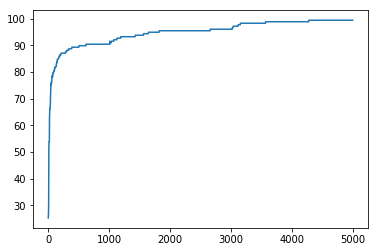

In [62]:
        # This is what we return at the end
model = initialize_parameters(nn_input_dim=13, nn_hdim=5, nn_output_dim=3)
model = train(model, X, y, learning_rate=0.07, epochs=5000, print_loss=True)
plt.plot(losses)   
plt.savefig('losses.png')